In [90]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as sklPp
import os
from sklearn.metrics import matthews_corrcoef,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from statistics import NormalDist
from BlackBoxAuditing.repairers.GeneralRepairer import Repairer
from scipy import stats 
import random
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<p>The data set split the data into a training and test sets, considering we may want to allocate those ourselves later we will combine the two.</p>

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',header=None)
test  = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',skiprows=[0],sep=',', header=None)
data = data.append(test)
data.rename(columns={0: "Age",1: "Workclass",2:"Final Weight",3:"Education",4:"Education_Num",5:"Marital-status",6:"Occupation",7:"Relationship",8:"Race",9:"Sex",10:"Capital-gain",11:"Capital-loss",12:"Hours/week",13:"Native_Country",14:"Result"},inplace = "True")
print(data.head(5))


   Age          Workclass  Final Weight   Education  Education_Num  \
0   39          State-gov         77516   Bachelors             13   
1   50   Self-emp-not-inc         83311   Bachelors             13   
2   38            Private        215646     HS-grad              9   
3   53            Private        234721        11th              7   
4   28            Private        338409   Bachelors             13   

        Marital-status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital-gain  Capital-loss  Hours/week  Native_Country  Result  
0          2174             0       

In [3]:
def cleanData(data):
    #Drop these columns as the data is mainly irrelevant.
    data.drop(['Capital-gain','Capital-loss',"Final Weight","Education"],axis =1,inplace = True)
    #Remove all rows where data is missing.
    for column in data.columns:
        #In the object columns, ? is used as NaN so remove them
        if data[column].dtypes == "object":
            data.drop(data[(data[column] == " ?")].index,inplace = True)
        #Remove any NaN values
        data = data[data[column].notnull()]
    data['Result'] = data['Result'].str.replace(">50K.",">50K")
    data['Result'] = data['Result'].str.replace("<=50K.","<=50K")
    #Reset index 
    data.reset_index(drop=True, inplace=True)
    return data

In [4]:
def createCombined(data):
    #To allow for analysis of multiple sensitive attributes, create a shared column
    data['Sex_Race'] = data['Sex']+data['Race']
    #Remove the old columns
    data.drop(['Sex','Race'],axis = 1,inplace = True)
    return data

In [5]:
cleaned = cleanData(data)
print("Cleaned \n",cleaned.head(5))
print("\n")
combined = createCombined(cleaned)
print("Combined \n",combined.head(5))


Cleaned 
    Age          Workclass  Education_Num       Marital-status  \
0   39          State-gov             13        Never-married   
1   50   Self-emp-not-inc             13   Married-civ-spouse   
2   38            Private              9             Divorced   
3   53            Private              7   Married-civ-spouse   
4   37            Private             14   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Hours/week  \
0        Adm-clerical   Not-in-family   White     Male          40   
1     Exec-managerial         Husband   White     Male          13   
2   Handlers-cleaners   Not-in-family   White     Male          40   
3   Handlers-cleaners         Husband   Black     Male          40   
4     Exec-managerial            Wife   White   Female          40   

   Native_Country  Result  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <=50K  
3   United-States   <=50K  
4   United-States   <=50K  


Combined

In [6]:
def analyseData(data):
    for sexRace in data['Sex_Race'].unique():
        demographicData = data.loc[data['Sex_Race'] == sexRace]
        #print(demographicData)
        print(sexRace)
        print("Size:",len(demographicData.index))
        print("Avg Age:", demographicData["Age"].mean())
        print("Mode Workclass:", demographicData["Workclass"].mode())
        print("Mode Education Num:", demographicData["Education_Num"].mode())
        print("Mode Marital Status:", demographicData["Marital-status"].mode())
        print("Mode Occupation:", demographicData["Occupation"].mode())
        print("Mode Relationship Status:", demographicData["Relationship"].mode())
        print("Avg Hours/week:", demographicData["Hours/week"].mean())
        print("Mode Native Country:", demographicData["Native_Country"].mode())
        print("Mode Result:", demographicData["Result"].mode())
        print("\n")

In [7]:
analyseData(combined)

 Male White
Size: 25667
Avg Age: 39.45720185452137
Mode Workclass: 0     Private
dtype: object
Mode Education Num: 0    9
dtype: int64
Mode Marital Status: 0     Married-civ-spouse
dtype: object
Mode Occupation: 0     Craft-repair
dtype: object
Mode Relationship Status: 0     Husband
dtype: object
Avg Hours/week: 43.12428410020649
Mode Native Country: 0     United-States
dtype: object
Mode Result: 0     <=50K
dtype: object


 Male Black
Size: 2050
Avg Age: 37.91268292682927
Mode Workclass: 0     Private
dtype: object
Mode Education Num: 0    9
dtype: int64
Mode Marital Status: 0     Married-civ-spouse
dtype: object
Mode Occupation: 0     Other-service
dtype: object
Mode Relationship Status: 0     Husband
dtype: object
Avg Hours/week: 40.3419512195122
Mode Native Country: 0     United-States
dtype: object
Mode Result: 0     <=50K
dtype: object


 Female White
Size: 11256
Avg Age: 36.84061833688699
Mode Workclass: 0     Private
dtype: object
Mode Education Num: 0    9
dtype: int64
Mode M

In [8]:
def encode(data):
    for column in data.columns:
        if data[column].dtypes == "object":
        #Create a label encoder
            lE = sklPp.LabelEncoder()
            data[column] = lE.fit_transform(data[column])
            mapping = dict(zip(lE.classes_, lE.transform(lE.classes_)))
            print(column,mapping)
    return data

In [9]:
encoded = encode(combined)
sexRaceVariety = encoded['Sex_Race'].value_counts()
print("Variety of Sex/Race \n",sexRaceVariety)

Workclass {' Federal-gov': 0, ' Local-gov': 1, ' Private': 2, ' Self-emp-inc': 3, ' Self-emp-not-inc': 4, ' State-gov': 5, ' Without-pay': 6}
Marital-status {' Divorced': 0, ' Married-AF-spouse': 1, ' Married-civ-spouse': 2, ' Married-spouse-absent': 3, ' Never-married': 4, ' Separated': 5, ' Widowed': 6}
Occupation {' Adm-clerical': 0, ' Armed-Forces': 1, ' Craft-repair': 2, ' Exec-managerial': 3, ' Farming-fishing': 4, ' Handlers-cleaners': 5, ' Machine-op-inspct': 6, ' Other-service': 7, ' Priv-house-serv': 8, ' Prof-specialty': 9, ' Protective-serv': 10, ' Sales': 11, ' Tech-support': 12, ' Transport-moving': 13}
Relationship {' Husband': 0, ' Not-in-family': 1, ' Other-relative': 2, ' Own-child': 3, ' Unmarried': 4, ' Wife': 5}
Native_Country {' Cambodia': 0, ' Canada': 1, ' China': 2, ' Columbia': 3, ' Cuba': 4, ' Dominican-Republic': 5, ' Ecuador': 6, ' El-Salvador': 7, ' England': 8, ' France': 9, ' Germany': 10, ' Greece': 11, ' Guatemala': 12, ' Haiti': 13, ' Holand-Netherlan

In [10]:
#Useful for debug
fileSystem = os.path.join(os.getcwd(),"encoded.csv")
encoded.to_csv(fileSystem, index = False, header=True)

In [11]:
def splitData(data):
    #x = data.iloc[:,[True,True,True,True,True,True,True,True,True,True,False,True]]
    #y = data.iloc[:,10]
    y = data['Result']
    x = data.drop(['Result'],axis =1)
    xTrain,xTest,yTrain,yTest = train_test_split(x, y, test_size=0.30)
    #valueIndexs = data.sample(frac = 0.7).index.values
    #train = data.iloc[valueIndexs]
    #test = data.drop(valueIndexs)
    #yTrain = train['Result']
    #yTest = test['Result']
    #xTrain = train.drop(['Result'],axis=1)
    #xTest = test.drop(['Result'],axis=1)
    return xTrain,xTest,yTrain,yTest 

In [175]:
def biasModel(xTrain,xTest,yTrain,yTest,data):
    #class_weight = "balanced"
    #class_weight = "balanced",bootstrap= True,max_features = 1,n_estimators = 50

    model = RandomForestClassifier().fit(xTrain, yTrain)
    #Commented out to improve speed, best features from this added to the model 
    #n_estimators = np.array([50,100,150,200,250])
    #max_features = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    #bootstrap = np.array([True,False])
    #parameterGrid = dict(n_estimators=n_estimators,max_features=max_features,bootstrap = bootstrap)
    #grid = GridSearchCV(estimator=model, param_grid=parameterGrid, scoring=matthews_corrcoef)
    #results = grid.fit(xTrain, yTrain)
    #print(results.best_score_, results.best_params_)
    
    
    testPredictions = list(model.predict(xTest))
    accuracy = accuracy_score(testPredictions , yTest)
    #print(testPredictions,yTest)
    combined = []
    rowList = data.values.tolist()
    #print(rowList[:10])
    for i in range(0,len(testPredictions)):
        combined.append(rowList[i] + [testPredictions[i]])
    return combined,model,accuracy

In [162]:
def evaluateFairness(results):
    #Defining privleged as white male/female
    #None-Priv as others
    priviliged = [4,9]
   
    privProb = 0
    privCount = 0
    nonPrivProb = 0
    nonPrivCount = 0
    for result in results:
        if result[-2] in priviliged:
            privCount += 1
            if result[-1] == 1:
                privProb += 1
        else:
            nonPrivCount += 1
            if result[-1] == 1:
                nonPrivProb +=1
    privProb = privProb/privCount
    nonPrivProb = nonPrivProb/nonPrivCount
    #fairness = nonPrivProb/privProb
    fairness = 1-(privProb-nonPrivProb)
    return fairness

In [48]:
def checkOverfit(xTrain,xTest,yTrain,yTest,model):
    testPredictions = list(model.predict(xTest))
    testAccuracy = accuracy_score(testPredictions , yTest)
    trainPredictions = list(model.predict(xTrain))
    trainAccuracy = accuracy_score(trainPredictions , yTrain)
    print("Test",testAccuracy, "Train",trainAccuracy)

In [18]:
def barChart(results):
    encoding = [' Female Amer-Indian-Eskimo', ' Female Asian-Pac-Islander', ' Female Black', ' Female Other', ' Female White', ' Male Amer-Indian-Eskimo', ' Male Asian-Pac-Islander', ' Male Black', ' Male Other', ' Male White']
    scoresBySexRace = {}
    for word in encoding:
        scoresBySexRace[word] = [0,0]
    for result in results:
        name = encoding[result[-2]]
        outcome = result[-1]
        scoresBySexRace[name][outcome] += 1
    plt.rcParams["figure.figsize"] = (40, 10)
    values = list(scoresBySexRace.values())
    x = [name.replace(' ', '\n') for name in encoding]
    x = [name.replace('-', '\n') for name in x]
    graphValues = []
    maleAvg = 0
    femaleAvg = 0
    for value in values:
        graphValues.append((value[1]/(sum(value)))*100)

    x_pos = [i for i, _ in enumerate(x)]
    
    plt.bar(x_pos, graphValues, color='teal')
    # plotting a line plot after changing it's width and height
    plt.xlabel("Sex/Race",fontsize = 40)
    plt.ylabel("Acceptance Rate",fontsize = 40)
    plt.title("Acceptance Rate by Sex/Race",fontsize = 40)
   
    plt.xticks(x_pos, x,fontsize=40)
    plt.yticks(fontsize = 30)
    plt.show()

9    17948
4     7927
7     1412
2     1379
6      583
1      285
5      181
8      158
0      109
3       91
Name: Sex_Race, dtype: int64
Test 0.8151769087523277 Train 0.967611066773078
Accuracy 0.8151769087523277
Fairness 0.9940072433319327


Test 0.8149441340782123 Train 0.9676443202979516
Accuracy 0.8149441340782123
Fairness 0.9944574504271965


Test 0.8156424581005587 Train 0.967611066773078
Accuracy 0.8156424581005587
Fairness 0.9957807864344872


Test 0.8163407821229051 Train 0.9676443202979516
Accuracy 0.8163407821229051
Fairness 0.9937371190747744


Test 0.8157200496585971 Train 0.967611066773078
Accuracy 0.8157200496585971
Fairness 0.9956216223098989


Test 0.8128491620111732 Train 0.9676443202979516
Accuracy 0.8128491620111732
Fairness 0.9932450745524759


Test 0.8150993171942893 Train 0.967611066773078
Accuracy 0.8150993171942893
Fairness 1.0013988252778097


Test 0.8150993171942893 Train 0.967511306198457
Accuracy 0.8150993171942893
Fairness 0.9914924501634388


Test 0.813

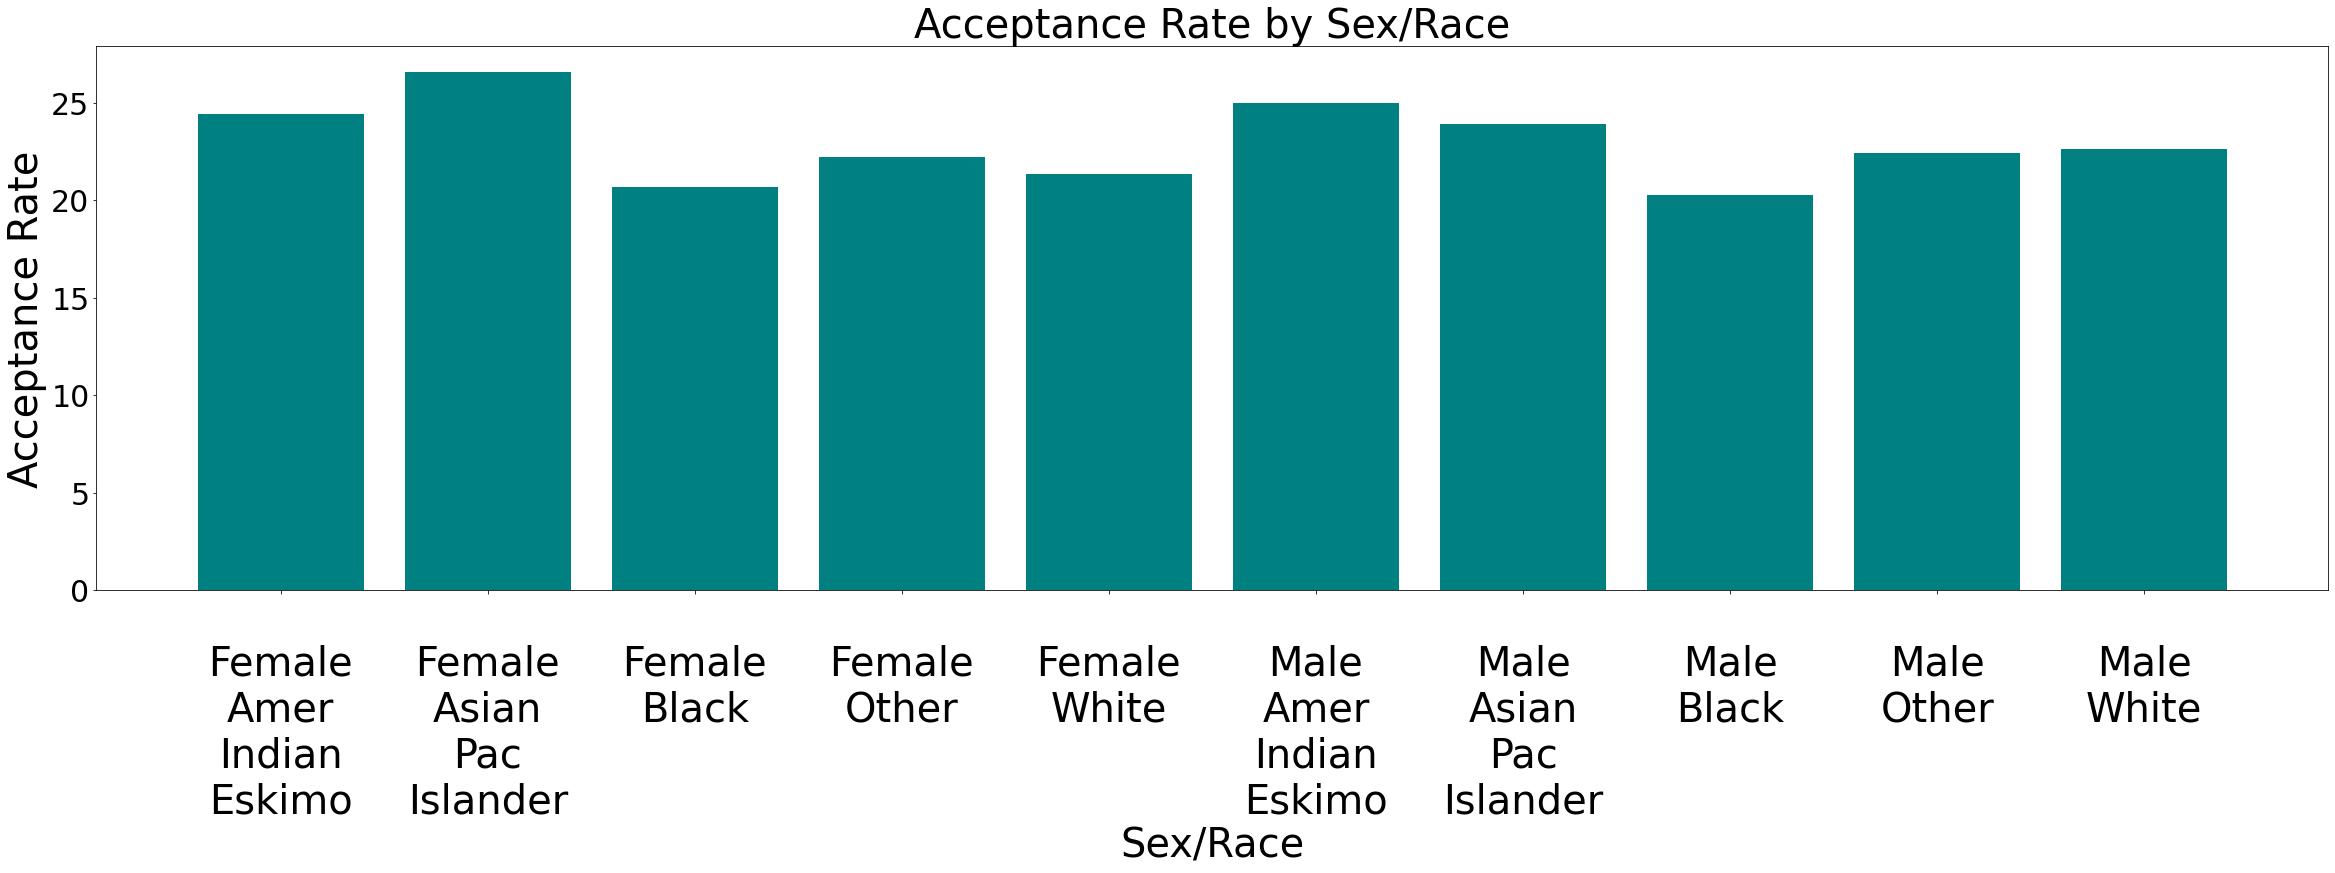

In [198]:
avgFairness = 0
avgAcc = 0
xTrain,xTest,yTrain,yTest = splitData(encoded)
print(xTrain2['Sex_Race'].value_counts())
for i in range(0,10):
    
    results,model,accuracy = biasModel(xTrain,xTest,yTrain,yTest,encoded)
    checkOverfit(xTrain,xTest,yTrain,yTest,model)
    fairness = evaluateFairness(results) 
    avgFairness += fairness
    avgAcc += accuracy
    print("Accuracy",accuracy)
    print("Fairness",fairness)
    print("\n")
    
avgFairness /= 10
avgAcc /= 10
print("Average Accuracy:",avgAcc,"Average Fairness",avgFairness)
barChart(results)


In [157]:
def resampleData(data):
    #For sex-race, going to pick 70% for training data, 30% for test
    possibleValues = data['Age'].unique()
    indexs = []
    for value in possibleValues:
        columns = data.loc[data['Age'] == value]
        #Create 
        valueIndexs = columns.sample(frac = 0.7).index.values
        indexs.extend(valueIndexs)
    random.shuffle(indexs)
    train = data.iloc[indexs]
    test = data.drop(indexs)
    yTrain = train['Result']
    yTest = test['Result']
    xTrain = train.drop(['Result'],axis=1)
    xTest = test.drop(['Result'],axis=1)
    
    #print(yTrain)
    #print(len(xTrain.index),len(xTest.index))
    return xTrain,xTest,yTrain,yTest

In [141]:
def test(data_df):
    repair_level = 1
    types = data_df.dtypes
    data = data_df.values.tolist()
    index_to_repair = data_df.columns.get_loc('Sex_Race')
    headers = data_df.columns.tolist()
    repairer = Repairer(data, index_to_repair, repair_level, False)
    data = repairer.repair(data)

    # The repaired data no longer includes its headers.
    data_df = pd.DataFrame(data, columns = headers)
    data_df = data_df.astype(dtype=types)
    print(data_df.head(30))
    return data_df

9    17948
4     7927
7     1412
2     1379
6      583
1      285
5      181
8      158
0      109
3       91
Name: Sex_Race, dtype: int64
Test 0.8105067121905797 Train 0.966581318790942
Accuracy 0.8105067121905797
Fairness 0.9994893776909417


Test 0.8107395049274463 Train 0.9665480663718286
Accuracy 0.8107395049274463
Fairness 0.9960992500121083


Test 0.8110498952432684 Train 0.9665480663718286
Accuracy 0.8110498952432684
Fairness 0.9962793328502139


Test 0.8112050904011795 Train 0.966581318790942
Accuracy 0.8112050904011795
Fairness 0.99944180386987


Test 0.8116706758749127 Train 0.9665148139527151
Accuracy 0.8116706758749127
Fairness 1.002529552139745


Test 0.8105067121905797 Train 0.9665480663718286
Accuracy 0.8105067121905797
Fairness 1.00335605248712


Test 0.8106619073484908 Train 0.9665480663718286
Accuracy 0.8106619073484908
Fairness 0.9985464959024329


Test 0.8089547606114689 Train 0.966581318790942
Accuracy 0.8089547606114689
Fairness 0.9962580990512233


Test 0.808799

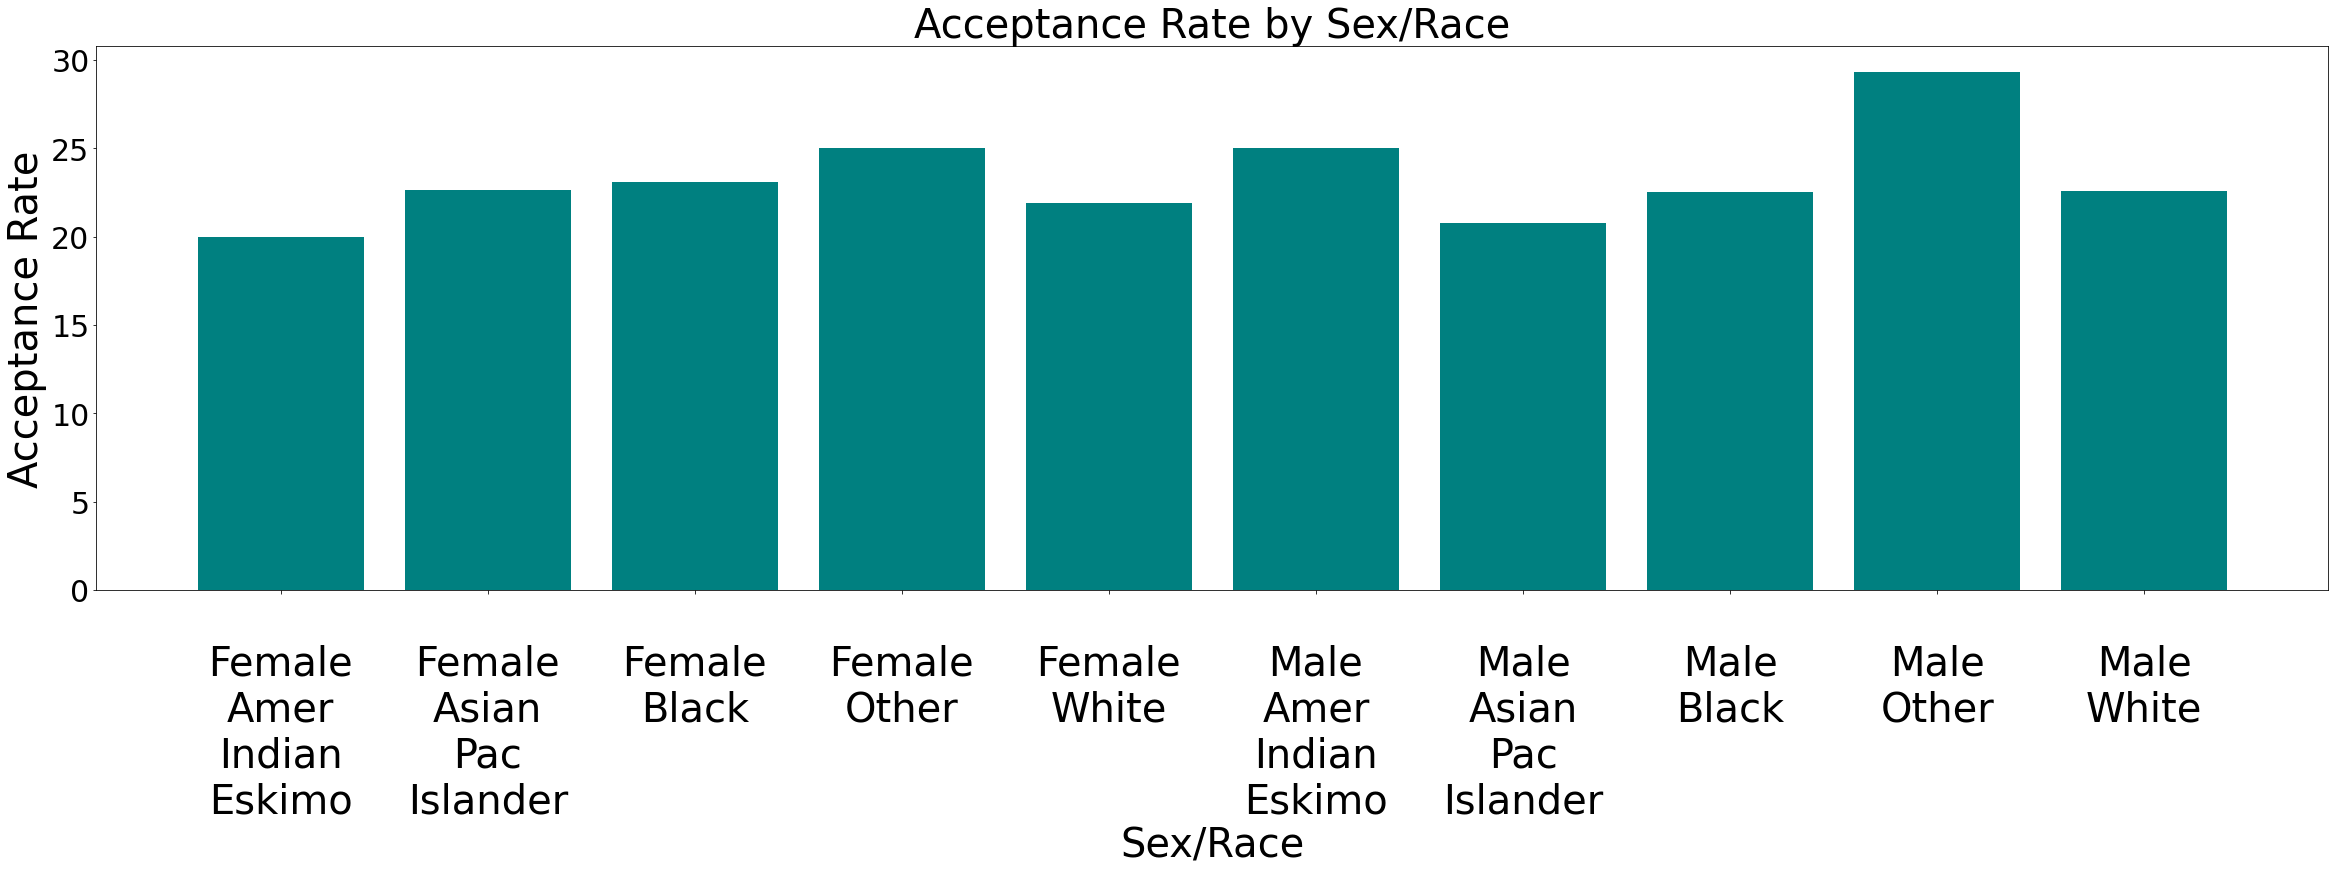

In [197]:
xTrain2,xTest2,yTrain2,yTest2 = resampleData(encoded)
#print(len(xTrain2.index))
#print(len(xTrain2.loc[xTrain2['Sex_Race'] == 9].index))
#print(len(xTrain2.loc[xTrain2['Sex_Race'] == 4].index))
print(xTrain2['Sex_Race'].value_counts())
for i in range(0,10):
    results,model,accuracy = biasModel(xTrain2,xTest2,yTrain2,yTest2,encoded)
    checkOverfit(xTrain2,xTest2,yTrain2,yTest2,model)
    fairness = evaluateFairness(results) 
    avgFairness += fairness
    avgAcc += accuracy
    print("Accuracy",accuracy)
    print("Fairness",fairness)
    print("\n")
    
avgFairness /= 10
avgAcc /= 10
print("Average Accuracy:",avgAcc,"Average Fairness",avgFairness)
barChart(results)

In [25]:
def removeDisImpact(sensitiveAttribute,data):
    uniqueSensAtts = data[sensitiveAttribute].unique()
    for column in data.columns:
        
        if column != sensitiveAttribute and column != "Result":
            #print(column)
            newValues = repairColumn(data,data[column],sensitiveAttribute,uniqueSensAtts)
            data[column] = newValues
    data = data.drop(sensitiveAttribute,axis = 1)
    return data

In [26]:
def repairColumn(data,column,sensAttr,uniqueSensAtts):
    medianMean,medianSTDs = getMeans(data,column,sensAttr,uniqueSensAtts)
    newValues = []
    for value in uniqueSensAtts:
        oldMedian = getMedian(data,column,sensAttr,value)
        columnValues = column.loc[data[sensAttr] == value].values
        #print(columnValues)
        for colVal in columnValues:
           
            percentile = stats.percentileofscore(columnValues, colVal)
        
            percentile /= 100
            #Removes rounding errors 
            percentile = max(percentile,0.01)
            percentile = min(percentile,0.99)
           # print(colVal,percentile)
            newScore = NormalDist(mu=medianMean, sigma=medianSTDs).inv_cdf(percentile)
            #newScore = stats.invnorm.pdf(percentile,medianMean,loc=medianSTDs)
            #invnorm.pdf(x,mu,loc=0,scale=1)
            #print(newScore)
            #newScore = stats.scoreatpercentile(means,percentile)
            newValues.append(int(round(newScore,0)))
    return newValues
    

In [27]:
def getMedian(data,column,sensAttr,value):
    values = column.loc[data[sensAttr] == value].values
    values.sort()
    median = int((values[len(values)//2]).round()) 
    return median

In [28]:
def getMeans(data,column,sensAttr,uniqueSensAtts):
    means = []
    stds = []
    for value in uniqueSensAtts:
        total = sum(column.loc[data[sensAttr] == value].values)
        mean = total/len(column.loc[data[sensAttr] == value].index)
        means.append(mean)
        std = np.std(column.loc[data[sensAttr] == value].values)
        stds.append(std)
    means.sort()
    stds.sort()
    medianMean = int((means[len(means)//2]).round())
    stdsMean = max(int((stds[len(stds)//2]).round()),0.01)
    return medianMean,stdsMean    

In [33]:
#print(encoded2.head(10))
#print("Pre")
#fixed = removeDisImpact("Sex_Race",encoded2)
xTrain,xTest,yTrain,yTest = resampleData(encoded)
#print(xTrain.head(10))
xTrain = removeDisImpact("Sex_Race",xTrain)
xTest = removeDisImpact("Sex_Race",xTest)
#print("Post",xTrain.head(10),"Y",yTrain.head(15))
#print("=========================================")
#testYTrain = test(yTrain2)
#yTrain = removeDisImpact("Sex_Race",xTrain)
fixedResults = biasModel(xTrain,xTest,yTrain,yTest,encoded)
#print("Results \n)",results[:10])
evaluateFairness(fixedResults)   
print("\n")
barChart(fixedResults)

Accuracy 0.6832466827034996
Fairness 1.004577905949033


